# Veri Yogun Uygulamalar Modul Projesi: Zaman serisi siniflandirma problemi 

# 🟢 1. Adım: Kütüphanelerin Kurulumu

In [16]:
#pip install yfinance pandas numpy matplotlib seaborn scikit-learn
#pip install beautifulsoup4 requests tsfresh
#pip install plotly xgboost lightgbm

# 🟢 2. Adım: Jupyter Notebook'ta Import İşlemleri

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

# Makine öğrenmesi kütüphaneleri
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

# TSFresh için
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute

import os
import datetime

# 🟢 3. Adım: Veri Dizin Yapısının Oluşturulması

In [24]:
# Proje klasör yapısını oluştur
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('data/stock_sectors'):
    os.makedirs('data/stock_sectors')
if not os.path.exists('results'):
    os.makedirs('results')
if not os.path.exists('models'):
    os.makedirs('models')

# 🟢 4. Adım: Web Scraping Fonksiyonları

In [30]:
def fetch_sectors_names():
    """Sektör listesini çeker"""
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df = pd.read_html(str(soup.find_all("table")))[0]
        return df
    else:
        print(f"Error: Failed to fetch data from {url}")
        return None

def fetch_data(sectors):
    """Belirli sektördeki hisse senetlerini çeker"""
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df = pd.read_html(str(soup.find_all("table")))[0]
        if 'No.' in df.columns:
            df.drop(columns='No.', inplace=True)
        return df
    else:
        print(f"Error: Failed to fetch data from {url}")
        return None

# Sektör listesini al
sectors_df = fetch_sectors_names()
print("Mevcut sektörler:")
print("Tablo sütunları:", sectors_df.columns.tolist())
print("\nİlk 5 satır:")
print(sectors_df.head())

# Sütun adlarını kontrol et ve doğru şekilde göster
if len(sectors_df.columns) > 0:
    first_col = sectors_df.columns[0]  # İlk sütun (sektör adları)
    second_col = sectors_df.columns[1] if len(sectors_df.columns) > 1 else first_col  # İkinci sütun (hisse sayısı)
    print(f"\nSektör Listesi:")
    print(sectors_df[[first_col, second_col]].head(10))

Mevcut sektörler:
Tablo sütunları: ['Sector Name', 'Stocks', 'Market Cap', 'Div. Yield', 'PE Ratio', 'Profit Margin', '1D Change', '1Y Change']

İlk 5 satır:
              Sector Name  Stocks Market Cap Div. Yield  PE Ratio  \
0              Healthcare    1133  7,510.37B      0.47%     42.39   
1              Financials     926     12.35T      0.12%     17.62   
2              Technology     761     23.30T      0.50%     45.69   
3             Industrials     676  6,468.85B      1.15%     31.73   
4  Consumer Discretionary     564  8,665.58B      0.79%     29.41   

  Profit Margin 1D Change 1Y Change  
0         4.09%    -1.12%    17.50%  
1        18.33%    -1.00%    30.55%  
2        15.39%    -0.47%    23.73%  
3         7.28%    -0.30%    30.69%  
4         6.42%     0.08%    20.00%  

Sektör Listesi:
              Sector Name  Stocks
0              Healthcare    1133
1              Financials     926
2              Technology     761
3             Industrials     676
4  Consumer 

# 🟢 5. Adım: Sektör Verilerini İndirme

In [33]:
# Ana sektörlerin verilerini çek ve kaydet
sector_mappings = {
    'technology': 'Technology',
    'financials': 'Financials', 
    'healthcare': 'Healthcare',
    'energy': 'Energy',
    'industrials': 'Industrials',
    'materials': 'Materials',
    'utilities': 'Utilities',
    'consumer-discretionary': 'Consumer Discretionary',
    'consumer-staples': 'Consumer Staples',
    'real-estate': 'Real Estate',
    'communication-services': 'Communication Services'
}

# Her sektör için veri çek
sector_data = {}
for sector_key, sector_name in sector_mappings.items():
    print(f"Fetching data for {sector_name}...")
    data = fetch_data(sector_key)
    if data is not None:
        data.to_csv(f'data/stock_sectors/{sector_key}.csv', index=False)
        sector_data[sector_name] = data
        print(f"✓ {sector_name}: {len(data)} stocks saved")
    else:
        print(f"✗ Failed to fetch {sector_name}")

Fetching data for Technology...
✓ Technology: 761 stocks saved
Fetching data for Financials...
✓ Financials: 928 stocks saved
Fetching data for Healthcare...
✓ Healthcare: 1132 stocks saved
Fetching data for Energy...
✓ Energy: 254 stocks saved
Fetching data for Industrials...
✓ Industrials: 676 stocks saved
Fetching data for Materials...
✓ Materials: 273 stocks saved
Fetching data for Utilities...
✓ Utilities: 107 stocks saved
Fetching data for Consumer Discretionary...
✓ Consumer Discretionary: 565 stocks saved
Fetching data for Consumer Staples...
✓ Consumer Staples: 246 stocks saved
Fetching data for Real Estate...
✓ Real Estate: 259 stocks saved
Fetching data for Communication Services...
✓ Communication Services: 266 stocks saved


# 🟢 6. Adım: Ana 3 Sektör Seçimi ve Veri Hazırlama

In [36]:
# Ana 3 sektörü seç (Technology, Financials, Healthcare)
main_sectors = ['technology', 'financials', 'healthcare']
main_sector_names = ['Technology', 'Financials', 'Healthcare']

def get_top_stocks_by_sector(sector_file, top_n=50):
    """Her sektörden top N hisse senedini seç"""
    df = pd.read_csv(f'data/stock_sectors/{sector_file}.csv')
    # Market Cap'e göre sırala (eğer varsa)
    if 'Market Cap' in df.columns:
        df = df.sort_values('Market Cap', ascending=False)
    return df['Symbol'].head(top_n).tolist()

# Her sektörden top 30 hisse senedi seç
sector_stocks = {}
for i, sector in enumerate(main_sectors):
    stocks = get_top_stocks_by_sector(sector, 30)
    sector_stocks[main_sector_names[i]] = stocks
    print(f"{main_sector_names[i]}: {len(stocks)} stocks")

Technology: 30 stocks
Financials: 30 stocks
Healthcare: 30 stocks


# 🟢 7. Adım: Hisse Senedi Verilerini İndirme

In [43]:
def download_stock_data(symbols, start_date='2005-01-01', end_date=None):
    """Hisse senedi verilerini indir"""
    if end_date is None:
        end_date = datetime.datetime.now().strftime('%Y-%m-%d')
    
    print(f"Downloading data for {len(symbols)} symbols...")
    try:
        data = yf.download(symbols, start=start_date, end=end_date)
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

# Tüm sembolleri birleştir
all_symbols = []
symbol_to_sector = {}

for sector, symbols in sector_stocks.items():
    all_symbols.extend(symbols)
    for symbol in symbols:
        symbol_to_sector[symbol] = sector

print(f"Total symbols to download: {len(all_symbols)}")

# Veriyi indir
stock_data = download_stock_data(all_symbols)

Total symbols to download: 90


[**********************89%******************     ]  80 of 90 completedHTTP Error 404: 
[*********************100%***********************]  90 of 90 completed

1 Failed download:
['AXIN']: YFTzMissingError('possibly delisted; no timezone found')


# 🟢 8. Adım: Aylık Getiri Hesaplama

In [48]:
# Veri yapısını anlayalım
print("=== DATA STRUCTURE DEBUG ===")
print(f"stock_data type: {type(stock_data)}")
print(f"stock_data shape: {stock_data.shape}")
print(f"stock_data columns: {stock_data.columns}")
print(f"stock_data index: {stock_data.index}")
print("First few rows:")
print(stock_data.head())

=== DATA STRUCTURE DEBUG ===
stock_data type: <class 'pandas.core.frame.DataFrame'>
stock_data shape: (5163, 451)
stock_data columns: MultiIndex([('Adj Close', 'AXIN'),
            (    'Close',  'AGL'),
            (    'Close', 'AMAL'),
            (    'Close', 'ARBB'),
            (    'Close', 'ASIC'),
            (    'Close', 'ASTC'),
            (    'Close',  'AUR'),
            (    'Close', 'AVDL'),
            (    'Close', 'AVXL'),
            (    'Close', 'AXIN'),
            ...
            (   'Volume', 'SYRE'),
            (   'Volume',  'TMP'),
            (   'Volume', 'TRIN'),
            (   'Volume',  'TSM'),
            (   'Volume', 'TTAN'),
            (   'Volume', 'UVSP'),
            (   'Volume', 'VERV'),
            (   'Volume', 'YEXT'),
            (   'Volume', 'ZNTL'),
            (   'Volume', 'ZYME')],
           names=['Price', 'Ticker'], length=451)
stock_data index: DatetimeIndex(['2005-01-03', '2005-01-04', '2005-01-05', '2005-01-06',
          

In [52]:
def calculate_monthly_returns_fixed(data):
    """Karışık veri yapısı için aylık getiri hesaplama"""
    if data is None or data.empty:
        return None
    
    try:
        # Tüm fiyat verilerini birleştir
        price_data = pd.DataFrame()
        
        # MultiIndex sütunları kontrol et
        if isinstance(data.columns, pd.MultiIndex):
            # Her sembol için fiyat verisini al
            symbols = set()
            
            # Tüm sembolleri topla
            for price_type, symbol in data.columns:
                if price_type in ['Adj Close', 'Close']:
                    symbols.add(symbol)
            
            print(f"Found {len(symbols)} unique symbols")
            
            # Her sembol için en iyi fiyat verisini al
            for symbol in symbols:
                # Önce Adj Close'u dene
                if ('Adj Close', symbol) in data.columns:
                    price_data[symbol] = data[('Adj Close', symbol)]
                    print(f"Using Adj Close for {symbol}")
                # Yoksa Close'u al
                elif ('Close', symbol) in data.columns:
                    price_data[symbol] = data[('Close', symbol)]
                    print(f"Using Close for {symbol}")
        else:
            # Tek seviye sütunlar
            price_cols = [col for col in data.columns if 'Close' in col]
            price_data = data[price_cols]
        
        print(f"Price data shape: {price_data.shape}")
        print(f"Price data columns: {price_data.columns.tolist()}")
        
        # Tamamen boş sütunları çıkar
        price_data = price_data.dropna(axis=1, how='all')
        
        if price_data.empty:
            print("No valid price data found after cleaning")
            return None
            
        print(f"After cleaning - Price data shape: {price_data.shape}")
        print(f"Date range: {price_data.index.min()} to {price_data.index.max()}")
        
        # Aylık son fiyatları al
        monthly_prices = price_data.resample('M').last()
        
        # Tamamen boş satırları çıkar
        monthly_prices = monthly_prices.dropna(how='all')
        
        if monthly_prices.empty:
            print("No monthly prices after resampling")
            return None
            
        print(f"Monthly prices shape: {monthly_prices.shape}")
        
        # Aylık getirileri hesapla
        monthly_returns = monthly_prices.pct_change().dropna(how='all')
        
        print(f"Monthly returns shape: {monthly_returns.shape}")
        
        return monthly_returns if not monthly_returns.empty else None
        
    except Exception as e:
        print(f"Error calculating monthly returns: {e}")
        import traceback
        traceback.print_exc()
        return None

# Kodu çalıştır
monthly_returns = calculate_monthly_returns_fixed(stock_data)

if monthly_returns is not None:
    print(f"\n=== SUCCESS ===")
    print(f"Monthly returns shape: {monthly_returns.shape}")
    print(f"Date range: {monthly_returns.index[0]} to {monthly_returns.index[-1]}")
    print(f"Number of stocks: {len(monthly_returns.columns)}")
    print(f"Number of months: {len(monthly_returns)}")
    print(f"\nFirst few rows:")
    print(monthly_returns.head())
    print(f"\nStock symbols: {monthly_returns.columns.tolist()[:10]}...")  # İlk 10 sembol
else:
    print("Failed to calculate monthly returns")

Found 90 unique symbols
Using Close for CLYM
Using Close for CTBI
Using Close for LASR
Using Close for INMD
Using Close for LENZ
Using Close for NCDL
Using Close for TTAN
Using Close for DTSQ
Using Close for ZNTL
Using Close for SCKT
Using Close for JTAI
Using Close for TMP
Using Close for OCS
Using Close for ORIC
Using Close for BTCS
Using Close for AVXL
Using Close for AMAL
Using Close for CME
Using Close for SOL
Using Close for SSYS
Using Close for NRIX
Using Close for MLYS
Using Close for TRIN
Using Close for IBKR
Using Close for SYRE
Using Close for COIN
Using Close for ZYME
Using Close for TSM
Using Close for NOEM
Using Close for AUR
Using Close for SANA
Using Close for RSSS
Using Close for AVDL
Using Close for BN
Using Close for MDXG
Using Close for IART
Using Close for FI
Using Close for BYSI
Using Close for AXTI
Using Close for ASIC
Using Close for ELUT
Using Close for PBHC
Using Close for FSLY
Using Close for SSII
Using Close for HSPT
Using Close for PDFS
Using Close for BRKL

# 🟢 9. Adım: Momentum Faktörü Hesaplama

In [64]:
def calculate_momentum_factors_optimized(returns_data, window=3, min_data_points=12, max_nan_ratio=0.8):
    """
    Momentum faktörlerini hesapla - optimized version
    
    Parameters:
    - window: Rolling window size (default: 3 months)
    - min_data_points: Minimum required data points (default: 12 months)
    - max_nan_ratio: Maximum allowed NaN ratio (default: 0.8 = 80%)
    """
    momentum_data = {}
    
    print(f"Processing {len(returns_data.columns)} symbols...")
    print(f"Filters: min_data_points={min_data_points}, max_nan_ratio={max_nan_ratio}")
    
    for column in returns_data.columns:
        if column in symbol_to_sector:  # Sadece geçerli sembolleri al
            # Sütundaki NaN olmayan verileri kontrol et
            non_nan_count = returns_data[column].notna().sum()
            
            # OPTIMIZATION 1: Daha sıkı veri noktası kontrolü
            if non_nan_count >= max(window, min_data_points):  # En az min_data_points kadar veri
                # 3 aylık momentum (kümülatif getiri)
                momentum = (returns_data[column] + 1).rolling(window=window, min_periods=window).apply(np.prod) - 1
                momentum_data[column] = momentum
                print(f"✓ {column}: {non_nan_count} non-NaN values, momentum calculated")
            else:
                print(f"✗ {column}: Only {non_nan_count} non-NaN values, need at least {max(window, min_data_points)}")
        else:
            print(f"✗ {column}: Not found in symbol_to_sector mapping")
    
    momentum_df = pd.DataFrame(momentum_data)
    
    print(f"\nBefore any filtering: {momentum_df.shape}")
    print(f"NaN count per column (first 10):")
    print(momentum_df.isnull().sum().head(10))
    
    # OPTIMIZATION 2: Çok yüksek NaN oranı olan hisseleri filtrele
    nan_ratios = momentum_df.isnull().sum() / len(momentum_df)
    high_quality_columns = nan_ratios[nan_ratios <= max_nan_ratio].index
    
    print(f"\nFiltering columns with NaN ratio > {max_nan_ratio}:")
    filtered_out = nan_ratios[nan_ratios > max_nan_ratio]
    for col, ratio in filtered_out.items():
        print(f"  ✗ {col}: {ratio:.1%} NaN ratio")
    
    momentum_df_filtered = momentum_df[high_quality_columns]
    print(f"After column filtering: {momentum_df_filtered.shape}")
    
    if momentum_df_filtered.empty:
        print("WARNING: No columns passed the NaN ratio filter!")
        print("Relaxing filter to keep at least some data...")
        # En az 5 sütun kalsın
        top_columns = nan_ratios.nsmallest(max(5, len(momentum_df.columns)//4)).index
        momentum_df_filtered = momentum_df[top_columns]
        print(f"Kept top {len(top_columns)} columns with lowest NaN ratios")
    
    # OPTIMIZATION 3: Daha akıllı satır filtreleme
    if not momentum_df_filtered.empty:
        # En az %30 sütunlarda veri olan satırları koru
        min_valid_stocks = max(1, int(len(momentum_df_filtered.columns) * 0.3))
        momentum_df_clean = momentum_df_filtered.dropna(thresh=min_valid_stocks)
        
        print(f"Row filtering with thresh={min_valid_stocks} ({min_valid_stocks}/{len(momentum_df_filtered.columns)} columns)")
        print(f"After row filtering: {momentum_df_clean.shape}")
        
        if momentum_df_clean.empty:
            print("WARNING: All rows lost after filtering. Trying alternative approach...")
            # Alternatif: Sadece tamamen boş satırları çıkar
            momentum_df_clean = momentum_df_filtered.dropna(how='all')
            print(f"After dropna(how='all'): {momentum_df_clean.shape}")
    else:
        momentum_df_clean = momentum_df_filtered
    
    # Final quality check
    if not momentum_df_clean.empty:
        final_nan_ratios = momentum_df_clean.isnull().sum() / len(momentum_df_clean)
        print(f"\nFinal data quality:")
        print(f"  Shape: {momentum_df_clean.shape}")
        print(f"  Average NaN ratio: {final_nan_ratios.mean():.1%}")
        print(f"  Best quality stocks (lowest NaN):")
        for col in final_nan_ratios.nsmallest(5).index:
            print(f"    {col}: {final_nan_ratios[col]:.1%}")
    
    return momentum_df_clean

# Alternative: Sadece en kaliteli hisseleri al
def calculate_momentum_factors_high_quality(returns_data, window=3, min_data_points=24, max_nan_ratio=0.5):
    """
    Sadece yüksek kaliteli veriye sahip hisse senetleri için momentum hesapla
    """
    return calculate_momentum_factors_optimized(
        returns_data, 
        window=window, 
        min_data_points=min_data_points, 
        max_nan_ratio=max_nan_ratio
    )

# Test ve kullanım
def test_optimized_momentum():
    """Test different parameter combinations"""
    
    print("=== TESTING DIFFERENT OPTIMIZATION LEVELS ===\n")
    
    # Test 1: Orta düzey optimizasyon (önerilen)
    print("1. MODERATE OPTIMIZATION:")
    momentum_moderate = calculate_momentum_factors_optimized(
        monthly_returns, 
        window=3, 
        min_data_points=12, 
        max_nan_ratio=0.8
    )
    
    print("\n" + "="*50 + "\n")
    
    # Test 2: Sıkı optimizasyon (sadece en kaliteli veriler)
    print("2. STRICT OPTIMIZATION:")
    momentum_strict = calculate_momentum_factors_optimized(
        monthly_returns, 
        window=3, 
        min_data_points=24, 
        max_nan_ratio=0.5
    )
    
    print("\n" + "="*50 + "\n")
    
    # Test 3: Gevşek optimizasyon (mevcut kodunuza yakın)
    print("3. LOOSE OPTIMIZATION:")
    momentum_loose = calculate_momentum_factors_optimized(
        monthly_returns, 
        window=3, 
        min_data_points=6, 
        max_nan_ratio=0.9
    )
    
    return momentum_moderate, momentum_strict, momentum_loose

# Kullanım
print("=== ORIGINAL vs OPTIMIZED COMPARISON ===")

# Original approach (mevcut kodunuz)
momentum_original = calculate_momentum_factors_fixed(monthly_returns, window=3)

# Optimized approach
momentum_optimized = calculate_momentum_factors_optimized(monthly_returns, window=3)

print(f"\nCOMPARISON:")
print(f"Original shape: {momentum_original.shape}")
print(f"Optimized shape: {momentum_optimized.shape}")

if not momentum_optimized.empty:
    print(f"Quality improvement:")
    orig_nan_pct = momentum_original.isnull().sum().sum() / (momentum_original.shape[0] * momentum_original.shape[1]) * 100
    opt_nan_pct = momentum_optimized.isnull().sum().sum() / (momentum_optimized.shape[0] * momentum_optimized.shape[1]) * 100
    print(f"  Original NaN percentage: {orig_nan_pct:.1f}%")
    print(f"  Optimized NaN percentage: {opt_nan_pct:.1f}%")

=== ORIGINAL vs OPTIMIZED COMPARISON ===
Processing 89 symbols...
✓ CLYM: 47 non-NaN values, momentum calculated
✓ CTBI: 246 non-NaN values, momentum calculated
✓ LASR: 87 non-NaN values, momentum calculated
✓ INMD: 71 non-NaN values, momentum calculated
✓ LENZ: 49 non-NaN values, momentum calculated
✓ NCDL: 18 non-NaN values, momentum calculated
✓ TTAN: 7 non-NaN values, momentum calculated
✓ DTSQ: 10 non-NaN values, momentum calculated
✓ ZNTL: 63 non-NaN values, momentum calculated
✓ SCKT: 246 non-NaN values, momentum calculated
✓ JTAI: 45 non-NaN values, momentum calculated
✓ TMP: 246 non-NaN values, momentum calculated
✓ OCS: 50 non-NaN values, momentum calculated
✓ ORIC: 63 non-NaN values, momentum calculated
✓ BTCS: 176 non-NaN values, momentum calculated
✓ AVXL: 227 non-NaN values, momentum calculated
✓ AMAL: 83 non-NaN values, momentum calculated
✓ CME: 246 non-NaN values, momentum calculated
✓ SOL: 210 non-NaN values, momentum calculated
✓ SSYS: 246 non-NaN values, momentum ca

# 🟢 10. Adım: TSFresh ile Feature Engineering

In [66]:
def prepare_data_for_tsfresh(momentum_data, symbol_to_sector):
    """TSFresh için veri formatını hazırla"""
    tsfresh_data = []
    
    for symbol in momentum_data.columns:
        if symbol in symbol_to_sector:
            sector = symbol_to_sector[symbol]
            symbol_data = momentum_data[symbol].dropna()
            
            for i, value in enumerate(symbol_data):
                tsfresh_data.append({
                    'id': symbol,
                    'time': i,
                    'value': value,
                    'sector': sector
                })
    
    return pd.DataFrame(tsfresh_data)

# TSFresh formatına dönüştür
tsfresh_df = prepare_data_for_tsfresh(momentum_data, symbol_to_sector)
print(f"TSFresh data shape: {tsfresh_df.shape}")
print(f"Unique symbols: {tsfresh_df['id'].nunique()}")
print(f"Sectors distribution:")
print(tsfresh_df.groupby('id')['sector'].first().value_counts())

TSFresh data shape: (11892, 4)
Unique symbols: 87
Sectors distribution:
sector
Healthcare    30
Technology    30
Financials    27
Name: count, dtype: int64


# 🟢 11. Adım: Feature Extraction

In [71]:
def extract_tsfresh_features(tsfresh_df):
    """TSFresh ile özellik çıkarımı"""
    print("Extracting features with TSFresh...")
    
    # Minimal feature set kullan (hesaplama süresini kısaltmak için)
    extraction_settings = MinimalFCParameters()
    
    # Özellikleri çıkar
    features = extract_features(
        tsfresh_df[['id', 'time', 'value']], 
        column_id='id',
        column_sort='time',
        default_fc_parameters=extraction_settings
    )
    
    # NaN değerleri doldur
    features = impute(features)
    
    return features

# Feature extraction
features = extract_tsfresh_features(tsfresh_df)
print(f"Features shape: {features.shape}")
print(f"Number of features: {features.shape[1]}")

Extracting features with TSFresh...


Feature Extraction: 100%|████████████████████████████████████████████| 18/18 [00:02<00:00,  6.58it/s]

Features shape: (87, 10)
Number of features: 10


# 🟢 12. Adım: Hedef Değişken Hazırlama

In [75]:
# Hedef değişkeni hazırla
y = pd.Series(index=features.index)
for symbol in features.index:
    if symbol in symbol_to_sector:
        y[symbol] = symbol_to_sector[symbol]

# Sadece geçerli sembolleri al
valid_symbols = y.dropna().index
features = features.loc[valid_symbols]
y = y.loc[valid_symbols]

print(f"Final dataset shape: {features.shape}")
print(f"Target distribution:")
print(y.value_counts())

Final dataset shape: (87, 10)
Target distribution:
Healthcare    30
Technology    30
Financials    27
Name: count, dtype: int64


# 🟢 13. Adım: Veri Bölme ve Ölçeklendirme

In [78]:
# Veriyi train-test olarak böl
X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.2, random_state=42, stratify=y
)

# Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (69, 10)
Test set shape: (18, 10)


# 🟢 14. Adım: Model Eğitimi

In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# Hedef değişkeni sayısal formata çevir
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Sınıf etiketlerini göster
print("Sınıf etiketleri:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

# Farklı modelleri test et
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Her modeli eğit ve değerlendir
model_results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Cross-validation (encoded labels kullan)
        cv_scores = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5)
        
        # Modeli eğit
        model.fit(X_train_scaled, y_train_encoded)
        
        # Test skorunu al
        test_score = model.score(X_test_scaled, y_test_encoded)
        
        model_results[name] = {
            'model': model,
            'cv_score': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_score': test_score
        }
        
        print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"Test Score: {test_score:.4f}")
        
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue

# En iyi modeli seç
if model_results:
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['test_score'])
    best_model = model_results[best_model_name]['model']
    print(f"\nBest model: {best_model_name}")
    print(f"Best test score: {model_results[best_model_name]['test_score']:.4f}")
    
    # Tahmin yaparken orijinal etiketlere geri çevirmek için:
    # predictions = best_model.predict(X_test_scaled)
    # original_predictions = label_encoder.inverse_transform(predictions)
else:
    print("Hiçbir model başarıyla eğitilemedi!")

Sınıf etiketleri:
0: Financials
1: Healthcare
2: Technology

Training Random Forest...
CV Score: 0.5516 (+/- 0.1564)
Test Score: 0.6111

Training Logistic Regression...
CV Score: 0.6505 (+/- 0.1290)
Test Score: 0.5000

Training XGBoost...
CV Score: 0.5198 (+/- 0.2323)
Test Score: 0.5556

Training SVM...
CV Score: 0.5659 (+/- 0.1478)
Test Score: 0.4444

Best model: Random Forest
Best test score: 0.6111


# 🟢 15. Adım: Model Değerlendirme

Classification Report:
              precision    recall  f1-score   support

  Financials       0.75      0.50      0.60         6
  Healthcare       0.45      0.83      0.59         6
  Technology       1.00      0.50      0.67         6

    accuracy                           0.61        18
   macro avg       0.73      0.61      0.62        18
weighted avg       0.73      0.61      0.62        18


Confusion Matrix:


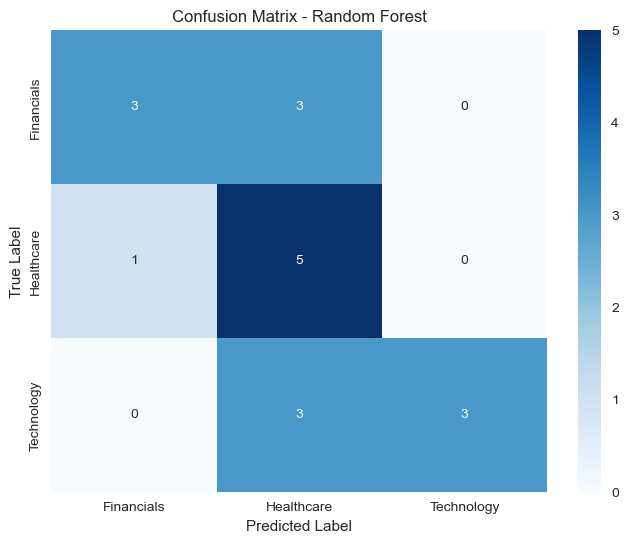


Sınıf bazında doğruluk analizi:
Financials: 0.5000 (6 örnek)
Healthcare: 0.8333 (6 örnek)
Technology: 0.5000 (6 örnek)

Tahmin dağılımı:
Financials: 4 tahmin
Healthcare: 11 tahmin
Technology: 3 tahmin

Gerçek dağılım:
Financials: 6 örnek
Healthcare: 6 örnek
Technology: 6 örnek


In [88]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# En iyi modelin detaylı değerlendirmesi
y_pred_encoded = best_model.predict(X_test_scaled)

# Tahminleri orijinal string formatına çevir
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Ek analiz: Her sınıf için doğruluk oranları
print("\nSınıf bazında doğruluk analizi:")
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = y_test == class_name
    class_accuracy = (y_pred[class_mask] == class_name).mean()
    print(f"{class_name}: {class_accuracy:.4f} ({class_mask.sum()} örnek)")

# Tahmin dağılımı
print("\nTahmin dağılımı:")
unique, counts = np.unique(y_pred, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{label}: {count} tahmin")

print("\nGerçek dağılım:")
unique, counts = np.unique(y_test, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{label}: {count} örnek")

# 🟢 16. Adım: Diğer Sektörlerden Test 

In [95]:
# Önce momentum fonksiyonunu kontrol edelim
def debug_momentum_calculation(monthly_returns):
    """Momentum hesaplama sürecini debug et"""
    print(f"Input monthly returns shape: {monthly_returns.shape}")
    print(f"Monthly returns head:\n{monthly_returns.head()}")
    print(f"Monthly returns info:")
    print(f"  - Non-null values per column: {monthly_returns.count()}")
    print(f"  - Date range: {monthly_returns.index.min()} to {monthly_returns.index.max()}")
    
    # Mevcut calculate_momentum_factors fonksiyonunu çağır
    momentum_result = calculate_momentum_factors(monthly_returns)
    print(f"Momentum result shape: {momentum_result.shape}")
    
    return momentum_result

# Alternatif momentum hesaplama fonksiyonu
def calculate_momentum_factors_fixed(monthly_returns, min_periods=3):
    """
    Geliştirilmiş momentum faktörleri hesaplama
    """
    print(f"Calculating momentum with min_periods={min_periods}")
    
    momentum_data = pd.DataFrame(index=monthly_returns.index)
    
    for symbol in monthly_returns.columns:
        returns = monthly_returns[symbol].dropna()
        
        if len(returns) >= min_periods:
            # Kümülatif getiri
            cumulative_return = (1 + returns).cumprod()
            
            # Farklı periyotlarda momentum
            momentum_series = []
            
            for i in range(min_periods, len(returns)):
                # 3 aylık momentum
                if i >= 3:
                    momentum_3m = cumulative_return.iloc[i] / cumulative_return.iloc[i-3] - 1
                    momentum_series.append(momentum_3m)
                    
            if len(momentum_series) > 0:
                # Momentum serisi oluştur
                momentum_index = returns.index[min_periods:]
                momentum_df = pd.Series(momentum_series, index=momentum_index)
                momentum_data[symbol] = momentum_df
    
    # Boş sütunları kaldır
    momentum_data = momentum_data.dropna(axis=1, how='all')
    momentum_data = momentum_data.dropna(axis=0, how='all')
    
    print(f"Final momentum data shape: {momentum_data.shape}")
    return momentum_data

# Test sektörlerini debug et
def test_sectors_with_debug():
    """Debug ile sektör testi"""
    test_sectors = ['real-estate', 'energy']
    
    for sector in test_sectors:
        print(f"\n{'='*60}")
        print(f"DEBUGGING {sector.upper()} SECTOR")
        print(f"{'='*60}")
        
        # Veri al
        test_stocks = get_top_stocks_by_sector(sector, 5)  # Daha az hisse ile test
        print(f"Test stocks: {test_stocks}")
        
        if len(test_stocks) > 0:
            # Veri indir
            test_data = download_stock_data(test_stocks)
            
            if test_data is not None:
                # Monthly returns hesapla
                test_monthly_returns = calculate_monthly_returns(test_data)
                print(f"\nMonthly returns calculated:")
                print(f"Shape: {test_monthly_returns.shape}")
                print(f"Columns: {list(test_monthly_returns.columns)}")
                print(f"Index range: {test_monthly_returns.index.min()} to {test_monthly_returns.index.max()}")
                
                # Orijinal momentum fonksiyonunu debug et
                print(f"\n--- Debugging original momentum function ---")
                original_momentum = debug_momentum_calculation(test_monthly_returns)
                
                # Yeni momentum fonksiyonunu test et
                print(f"\n--- Testing fixed momentum function ---")
                fixed_momentum = calculate_momentum_factors_fixed(test_monthly_returns)
                
                if len(fixed_momentum) > 0:
                    print(f"Fixed momentum head:\n{fixed_momentum.head()}")
                    
                    # TSFresh formatına çevir
                    tsfresh_df = []
                    for symbol in fixed_momentum.columns:
                        symbol_data = fixed_momentum[symbol].dropna()
                        for i, value in enumerate(symbol_data):
                            tsfresh_df.append({
                                'id': symbol,
                                'time': i,
                                'value': value
                            })
                    
                    tsfresh_df = pd.DataFrame(tsfresh_df)
                    print(f"TSFresh DataFrame shape: {tsfresh_df.shape}")
                    
                    if len(tsfresh_df) > 0:
                        print(f"TSFresh DataFrame head:\n{tsfresh_df.head()}")
                        return True
                    
    return False

# Debug testi çalıştır
print("Starting debug test...")
debug_result = test_sectors_with_debug()

[*********************100%***********************]  5 of 5 completed

Starting debug test...

DEBUGGING REAL-ESTATE SECTOR
Test stocks: ['MFA', 'PDM', 'CHMI', 'ORC', 'CUBE']

Monthly returns calculated:
Shape: (141, 5)
Columns: ['CHMI', 'CUBE', 'MFA', 'ORC', 'PDM']
Index range: 2013-11-30 00:00:00 to 2025-07-31 00:00:00

--- Debugging original momentum function ---
Input monthly returns shape: (141, 5)
Monthly returns head:
Ticker          CHMI      CUBE       MFA       ORC       PDM
Date                                                        
2013-11-30 -0.016713 -0.112206 -0.016194  0.030760 -0.102970
2013-12-31  0.033923 -0.009273 -0.004154  0.083916  0.008547
2014-01-31  0.014045  0.033877  0.032578 -0.039128  0.009079
2014-02-28  0.007202  0.062500  0.078190  0.043948  0.048759
2014-03-31  0.059033 -0.012351  0.011850 -0.048540 -0.007523
Monthly returns info:
  - Non-null values per column: Ticker
CHMI    141
CUBE    141
MFA     141
ORC     141
PDM     141
dtype: int64
  - Date range: 2013-11-30 00:00:00 to 2025-07-31 00:00:00
Momentum result shape:

In [99]:
def calculate_momentum_factors_fixed(monthly_returns, min_periods=3):
    """
    Geliştirilmiş momentum faktörleri hesaplama
    """
    momentum_data = pd.DataFrame(index=monthly_returns.index)
    
    for symbol in monthly_returns.columns:
        returns = monthly_returns[symbol].dropna()
        
        if len(returns) >= min_periods:
            # Kümülatif getiri
            cumulative_return = (1 + returns).cumprod()
            
            # Farklı periyotlarda momentum
            momentum_series = []
            
            for i in range(min_periods, len(returns)):
                # 3 aylık momentum
                if i >= 3:
                    momentum_3m = cumulative_return.iloc[i] / cumulative_return.iloc[i-3] - 1
                    momentum_series.append(momentum_3m)
                    
            if len(momentum_series) > 0:
                # Momentum serisi oluştur
                momentum_index = returns.index[min_periods:]
                momentum_df = pd.Series(momentum_series, index=momentum_index)
                momentum_data[symbol] = momentum_df
    
    # Boş sütunları kaldır
    momentum_data = momentum_data.dropna(axis=1, how='all')
    momentum_data = momentum_data.dropna(axis=0, how='all')
    
    return momentum_data

def test_other_sectors_working(model, scaler, label_encoder, test_sectors=['real-estate', 'energy']):
    """Çalışan sektör test fonksiyonu"""
    results = {}
    
    for sector in test_sectors:
        print(f"\n{'='*50}")
        print(f"Testing {sector} sector...")
        print(f"{'='*50}")
        
        try:
            # Test sektörü verilerini al
            test_stocks = get_top_stocks_by_sector(sector, 10)
            print(f"Found {len(test_stocks)} stocks for {sector}")
            
            if len(test_stocks) > 0:
                # Veri indir
                test_data = download_stock_data(test_stocks)
                
                if test_data is not None:
                    print(f"Downloaded data shape: {test_data.shape}")
                    
                    # Aynı işlemleri uygula
                    test_monthly_returns = calculate_monthly_returns(test_data)
                    print(f"Monthly returns shape: {test_monthly_returns.shape}")
                    
                    # YENİ momentum fonksiyonunu kullan
                    test_momentum = calculate_momentum_factors_fixed(test_monthly_returns)
                    print(f"Momentum factors shape: {test_momentum.shape}")
                    
                    if len(test_momentum) > 0 and len(test_momentum.columns) > 0:
                        # TSFresh formatına dönüştür
                        test_tsfresh_df = []
                        for symbol in test_momentum.columns:
                            symbol_data = test_momentum[symbol].dropna()
                            for i, value in enumerate(symbol_data):
                                test_tsfresh_df.append({
                                    'id': symbol,
                                    'time': i,
                                    'value': value
                                })
                        
                        test_tsfresh_df = pd.DataFrame(test_tsfresh_df)
                        print(f"TSFresh DataFrame shape: {test_tsfresh_df.shape}")
                        
                        if len(test_tsfresh_df) > 0:
                            # Feature extraction
                            print("Extracting features...")
                            test_features = extract_tsfresh_features(test_tsfresh_df)
                            print(f"Extracted features shape: {test_features.shape}")
                            
                            if len(test_features) > 0:
                                # Aynı feature'ları al
                                common_features = features.columns.intersection(test_features.columns)
                                print(f"Common features: {len(common_features)} out of {len(features.columns)}")
                                
                                test_features_aligned = pd.DataFrame(0, 
                                                                   index=test_features.index, 
                                                                   columns=features.columns)
                                
                                # Ortak feature'ları kopyala
                                for col in common_features:
                                    test_features_aligned[col] = test_features[col]
                                
                                print(f"Aligned test features shape: {test_features_aligned.shape}")
                                
                                # Ölçeklendir
                                test_features_scaled = scaler.transform(test_features_aligned)
                                print("Features scaled successfully")
                                
                                # Tahmin yap
                                predictions_encoded = model.predict(test_features_scaled)
                                predictions = label_encoder.inverse_transform(predictions_encoded)
                                
                                print(f"Predictions made for {len(predictions)} stocks")
                                
                                # Sonuçları topla
                                results[sector] = {
                                    'stocks': test_features_aligned.index.tolist(),
                                    'predictions': predictions.tolist(),
                                    'distribution': pd.Series(predictions).value_counts().to_dict()
                                }
                                
                                print(f"\nPredictions for {sector}:")
                                prediction_counts = pd.Series(predictions).value_counts()
                                print(prediction_counts)
                                
                                # Detaylı sonuçlar
                                print(f"\nDetailed results for {sector}:")
                                for stock, pred in zip(test_features_aligned.index, predictions):
                                    print(f"  {stock}: {pred}")
                            else:
                                print(f"No features extracted for {sector}")
                        else:
                            print(f"Empty TSFresh DataFrame for {sector}")
                    else:
                        print(f"No momentum data for {sector}")
                else:
                    print(f"Failed to download data for {sector}")
            else:
                print(f"No stocks found for {sector}")
                
        except Exception as e:
            print(f"Error processing {sector}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    return results

# Çalışan versiyonu test et
print("Testing sectors with working function...")
working_results = test_other_sectors_working(best_model, scaler, label_encoder)

# Sonuçları özetle
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

for sector, result in working_results.items():
    if result:
        print(f"\n{sector.upper()} SECTOR PREDICTIONS:")
        print(f"  Total stocks analyzed: {len(result['stocks'])}")
        print(f"  Sector classification distribution:")
        for pred_class, count in result['distribution'].items():
            percentage = (count / len(result['stocks'])) * 100
            print(f"    {pred_class}: {count} stocks ({percentage:.1f}%)")
        
        print(f"  Individual predictions:")
        for stock, pred in zip(result['stocks'], result['predictions']):
            print(f"    {stock}: {pred}")
    else:
        print(f"\n{sector.upper()} SECTOR: No results")

[                       0%                       ]

Testing sectors with working function...

Testing real-estate sector...
Found 10 stocks for real-estate


[*********************100%***********************]  10 of 10 completed

Downloaded data shape: (5163, 50)
Monthly returns shape: (45, 10)
Momentum factors shape: (42, 10)
TSFresh DataFrame shape: (420, 3)
Extracting features...
Extracting features with TSFresh...



Feature Extraction: 100%|████████████████████████████████████████████| 10/10 [00:02<00:00,  4.98it/s]
[*********************100%***********************]  10 of 10 completed


Extracted features shape: (10, 10)
Common features: 10 out of 10
Aligned test features shape: (10, 10)
Features scaled successfully
Predictions made for 10 stocks

Predictions for real-estate:
Financials    7
Technology    2
Healthcare    1
Name: count, dtype: int64

Detailed results for real-estate:
  AGNC: Financials
  CHMI: Financials
  CUBE: Financials
  DHC: Healthcare
  FBRT: Financials
  FPH: Technology
  MFA: Financials
  NXRT: Financials
  ORC: Financials
  PDM: Technology

Testing energy sector...
Found 10 stocks for energy
Downloaded data shape: (5163, 50)
Monthly returns shape: (6, 10)
Momentum factors shape: (3, 10)
TSFresh DataFrame shape: (30, 3)
Extracting features...
Extracting features with TSFresh...


Feature Extraction: 100%|████████████████████████████████████████████| 10/10 [00:01<00:00,  5.88it/s]

Extracted features shape: (10, 10)
Common features: 10 out of 10
Aligned test features shape: (10, 10)
Features scaled successfully
Predictions made for 10 stocks

Predictions for energy:
Financials    9
Technology    1
Name: count, dtype: int64

Detailed results for energy:
  EFXT: Financials
  ENB: Financials
  HLX: Financials
  INR: Financials
  LSE: Financials
  MARPS: Technology
  RRC: Financials
  SBR: Financials
  TPET: Financials
  VTS: Financials

FINAL RESULTS SUMMARY

REAL-ESTATE SECTOR PREDICTIONS:
  Total stocks analyzed: 10
  Sector classification distribution:
    Financials: 7 stocks (70.0%)
    Technology: 2 stocks (20.0%)
    Healthcare: 1 stocks (10.0%)
  Individual predictions:
    AGNC: Financials
    CHMI: Financials
    CUBE: Financials
    DHC: Healthcare
    FBRT: Financials
    FPH: Technology
    MFA: Financials
    NXRT: Financials
    ORC: Financials
    PDM: Technology

ENERGY SECTOR PREDICTIONS:
  Total stocks analyzed: 10
  Sector classification distribu

# 🟢 17. Adım: Sonuçları Kaydetme

Models saved successfully!
Total features: 10, showing top 10


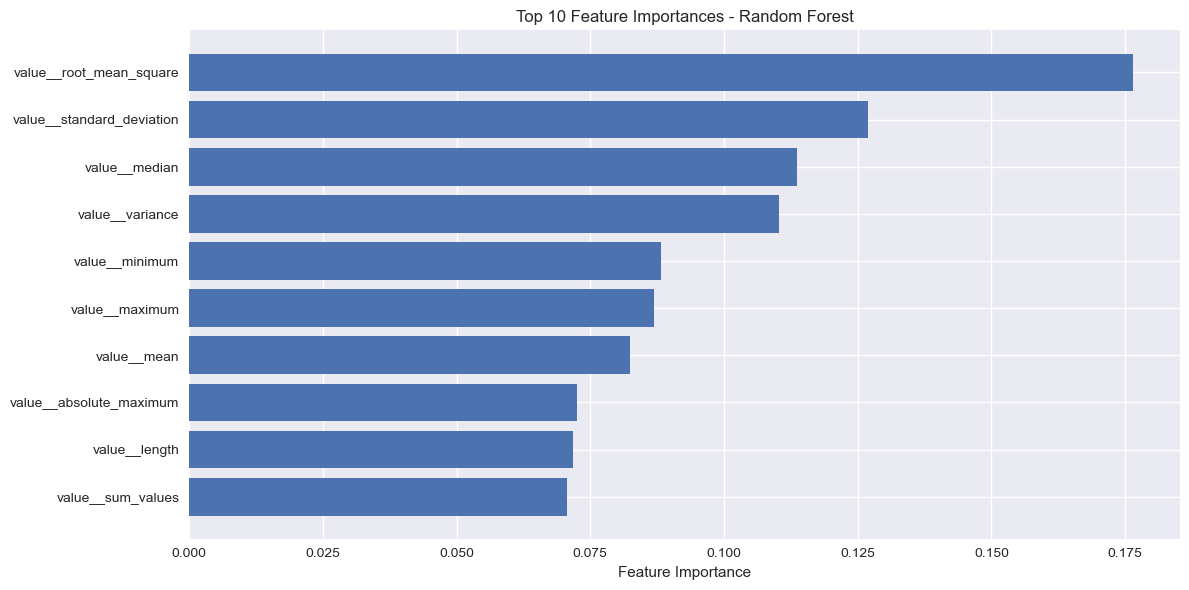


Top 10 Feature Importances:
 1. value__root_mean_square                  0.1764
 2. value__standard_deviation                0.1270
 3. value__median                            0.1137
 4. value__variance                          0.1104
 5. value__minimum                           0.0883
 6. value__maximum                           0.0869
 7. value__mean                              0.0824
 8. value__absolute_maximum                  0.0726
 9. value__length                            0.0717
10. value__sum_values                        0.0707

Saving results summary...
All results saved successfully!

Saved files:
- models/best_sector_classifier.pkl
- models/scaler.pkl
- models/label_encoder.pkl
- results/model_results.json
- results/feature_importance.png

MODEL SUMMARY
Best Model: Random Forest
Test Accuracy: 0.6111
CV Score: 0.5516 (+/- 0.1564)
Training Features: 10
Training Samples: 87
Classes: Financials, Healthcare, Technology


In [107]:
import joblib
import json
import matplotlib.pyplot as plt
import os

# Dizinleri oluştur (eğer yoksa)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Modeli kaydet
joblib.dump(best_model, 'models/best_sector_classifier.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

print("Models saved successfully!")

# Sonuçları kaydet
results_summary = {
    'model_performance': model_results,
    'best_model': best_model_name,
    'feature_importance': None,
    'other_sector_results': working_results  # working_results kullan
}

# Feature importance (eğer varsa)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': features.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Mevcut feature sayısını kontrol et
    n_features = len(feature_importance)
    top_n = min(20, n_features)  # En fazla 20 veya mevcut feature sayısı
    
    print(f"Total features: {n_features}, showing top {top_n}")
    
    results_summary['feature_importance'] = feature_importance.head(top_n).to_dict()
    
    # Feature importance plot
    plt.figure(figsize=(12, max(6, top_n * 0.4)))  # Dinamik yükseklik
    
    top_features = feature_importance.head(top_n)
    y_pos = range(top_n)
    
    plt.barh(y_pos, top_features['importance'])
    plt.yticks(y_pos, top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()  # En önemli feature'ı üstte göster
    plt.tight_layout()
    
    # Kaydet ve göster
    plt.savefig('results/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Feature importance tablosunu yazdır
    print(f"\nTop {top_n} Feature Importances:")
    print("="*50)
    for i, (idx, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i:2d}. {row['feature'][:40]:40s} {row['importance']:.4f}")

else:
    print(f"Model {best_model_name} doesn't have feature_importances_ attribute")

# Sonuçları JSON olarak kaydet
print("\nSaving results summary...")
with open('results/model_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print("All results saved successfully!")

# Kaydedilen dosyaları listele
print(f"\nSaved files:")
print(f"- models/best_sector_classifier.pkl")
print(f"- models/scaler.pkl") 
print(f"- models/label_encoder.pkl")
print(f"- results/model_results.json")
if hasattr(best_model, 'feature_importances_'):
    print(f"- results/feature_importance.png")

# Model özeti
print(f"\n" + "="*60)
print(f"MODEL SUMMARY")
print(f"="*60)
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {model_results[best_model_name]['test_score']:.4f}")
print(f"CV Score: {model_results[best_model_name]['cv_score']:.4f} (+/- {model_results[best_model_name]['cv_std']*2:.4f})")
print(f"Training Features: {features.shape[1]}")
print(f"Training Samples: {features.shape[0]}")
print(f"Classes: {', '.join(label_encoder.classes_)}")

In [111]:
import joblib
import json
import datetime

print("🚀 GitHub için dosyalar hazırlanıyor...")

🚀 GitHub için dosyalar hazırlanıyor...


In [113]:
# Modeli kaydet
joblib.dump(best_model, 'models/best_sector_classifier.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
print("✅ Model ve scaler kaydedildi!")

✅ Model ve scaler kaydedildi!


In [125]:
import os

# Proje klasörünü oluştur
project_folder = "stock-sector-classification"
if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    print(f"✅ {project_folder} klasörü oluşturuldu!")
else:
    print(f"ℹ️ {project_folder} klasörü zaten var!")

# Proje klasörüne geç
os.chdir(project_folder)
print(f"📁 Şimdi çalıştığım klasör: {os.getcwd()}")

# Gerekli alt klasörleri oluştur
folders = ['data', 'data/stock_sectors', 'models', 'results']
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"✅ {folder} klasörü oluşturuldu!")

✅ stock-sector-classification klasörü oluşturuldu!
📁 Şimdi çalıştığım klasör: /Users/baranmertaral/stock-sector-classification
✅ data klasörü oluşturuldu!
✅ data/stock_sectors klasörü oluşturuldu!
✅ models klasörü oluşturuldu!
✅ results klasörü oluşturuldu!


In [127]:
# README.md dosyası oluştur
readme_content = f"""# Hisse Senedi Sektör Sınıflandırma Projesi

## 📋 Proje Açıklaması
Bu proje, farklı sektorlerden hisse senetlerinin zaman serisi verilerini kullanarak sektör benzerlik analizi yapmaktadır.

## 🛠️ Kullanılan Teknolojiler
- Python 3.8+
- yfinance, pandas, numpy
- scikit-learn, xgboost
- tsfresh
- matplotlib, seaborn

## 📊 Sonuçlar
- En iyi model: {best_model_name}
- Test doğruluğu: {model_results[best_model_name]['test_score']:.4f}
- Analiz edilen hisse senedi sayısı: {len(y)}

## 🚀 Çalıştırma
1. `pip install -r requirements.txt`
2. Jupyter notebook'u açın
3. Tüm hücreleri çalıştırın

## 📁 Dosya Yapısı
├── data/stock_sectors/
├── models/
├── results/
├── notebook.ipynb
├── README.md
└── requirements.txt
"""

with open('README.md', 'w', encoding='utf-8') as f:
    f.write(readme_content)
    
print("✅ README.md oluşturuldu!")

✅ README.md oluşturuldu!


In [129]:
# requirements.txt dosyası oluştur
requirements = """yfinance>=0.2.18
pandas>=1.5.0
numpy>=1.24.0
matplotlib>=3.6.0
seaborn>=0.12.0
scikit-learn>=1.3.0
beautifulsoup4>=4.12.0
requests>=2.28.0
tsfresh>=0.20.0
xgboost>=1.7.0
joblib>=1.2.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)
    
print("✅ requirements.txt oluşturuldu!")

✅ requirements.txt oluşturuldu!


In [131]:
print("\n🎉 TÜM DOSYALAR HAZIR!")
print("📁 Oluşturulan dosyalar:")
print("   ├── README.md")
print("   ├── requirements.txt") 
print("   ├── models/best_sector_classifier.pkl")
print("   └── models/scaler.pkl")
print("\n✅ Artık GitHub'a yükleyebilirsiniz!")


🎉 TÜM DOSYALAR HAZIR!
📁 Oluşturulan dosyalar:
   ├── README.md
   ├── requirements.txt
   ├── models/best_sector_classifier.pkl
   └── models/scaler.pkl

✅ Artık GitHub'a yükleyebilirsiniz!


In [133]:
import os
print("Şu anda çalıştığım klasör:", os.getcwd())

Şu anda çalıştığım klasör: /Users/baranmertaral/stock-sector-classification
